In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

from utils import load_dataset, train, plot_roc, auc
from einops import rearrange

In [2]:
X_train, y_train, X_test, y_test = load_dataset("FOX_0.75")

In [3]:
model = Sequential(
    [
        Input((1000, 4)),
        Conv1D(200, kernel_size=26, activation="relu"),
        MaxPooling1D(pool_size=13, strides=13),
        Dropout(0.2),
        Bidirectional(LSTM(200, return_sequences=True)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(9, activation="sigmoid"),
    ],
    name="conv-lstm",
)

es = EarlyStopping(monitor="val_loss", patience=5)
optimizer = Adam(lr=1e-3)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[AUC(multi_label=True), "acc"],
)

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.math import exp

def scheduler(epoch, lr):
    if epoch < 10:
        return lr

    return lr * exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

Epoch 1/60
1155/1155 - 48s - loss: 0.3574 - auc: 0.7140 - acc: 0.3297 - val_loss: 0.3222 - val_auc: 0.7914 - val_acc: 0.3980
Epoch 2/60
1155/1155 - 43s - loss: 0.3225 - auc: 0.7898 - acc: 0.3992 - val_loss: 0.3127 - val_auc: 0.8139 - val_acc: 0.3994
Epoch 3/60
1155/1155 - 44s - loss: 0.3103 - auc: 0.8144 - acc: 0.4213 - val_loss: 0.3023 - val_auc: 0.8305 - val_acc: 0.4442
Epoch 4/60
1155/1155 - 44s - loss: 0.3009 - auc: 0.8300 - acc: 0.4397 - val_loss: 0.2955 - val_auc: 0.8440 - val_acc: 0.4572
Epoch 5/60
1155/1155 - 44s - loss: 0.2921 - auc: 0.8429 - acc: 0.4583 - val_loss: 0.2904 - val_auc: 0.8483 - val_acc: 0.4525
Epoch 6/60
1155/1155 - 44s - loss: 0.2827 - auc: 0.8576 - acc: 0.4751 - val_loss: 0.2868 - val_auc: 0.8522 - val_acc: 0.4641
Epoch 7/60
1155/1155 - 44s - loss: 0.2719 - auc: 0.8735 - acc: 0.4975 - val_loss: 0.2884 - val_auc: 0.8507 - val_acc: 0.4627
Epoch 8/60
1155/1155 - 44s - loss: 0.2573 - auc: 0.8926 - acc: 0.5267 - val_loss: 0.2970 - val_auc: 0.8420 - val_acc: 0.4367


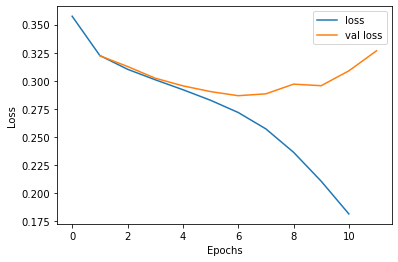

Training time: 8.12 minutes


In [5]:
model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=60,
    validation_freq=1,
    callbacks=[es, lr_schedule],
    verbose=2,
    batch_size=100,
)

In [6]:
model.save(f"../model_saves/final/{model.name}_75.h5")